# Task 14: Retail Sales ETL Pipeline

## Objective
Build a robust ETL (Extract, Transform, Load) pipeline to process the Retail Sales Dataset.

**Steps:**
1. **Extract**: Load raw data.
2. **Transform**: Clean, standardize, and feature engineer.
3. **Load**: Export to CSV and SQLite.
4. **Analysis**: Visualizations and insights.

In [1]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns

# specific formatting
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 1. Extract Phase

In [2]:
# Define paths
BASE_DIR = r'd:\Projects\Elevate Labs\Task 14'
RAW_DIR = os.path.join(BASE_DIR, 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

DATASET_PATH = os.path.join(RAW_DIR, 'retail_sales_dataset.csv')

# Check if file exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

# Load dataset
df = pd.read_csv(DATASET_PATH)
print(f"Dataset loaded successfully. Shape: {df.shape}")
df.head()

Dataset loaded successfully. Shape: (1000, 9)


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


## 2. Transform Phase

In [3]:
# Information about dataset before cleaning
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Transaction ID    1000 non-null   int64
 1   Date              1000 non-null   str  
 2   Customer ID       1000 non-null   str  
 3   Gender            1000 non-null   str  
 4   Age               1000 non-null   int64
 5   Product Category  1000 non-null   str  
 6   Quantity          1000 non-null   int64
 7   Price per Unit    1000 non-null   int64
 8   Total Amount      1000 non-null   int64
dtypes: int64(5), str(4)
memory usage: 70.4 KB


In [4]:
# check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

# remove duplicates if any
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

Number of duplicates: 0


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Handle missing values (if any)
# df = df.dropna() # Uncomment if needed

Missing values per column:
Series([], dtype: int64)


In [6]:
# Standardize column names (lowercase, replace spaces with underscores)
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
print("New column names:", df.columns.tolist())

New column names: ['transaction_id', 'date', 'customer_id', 'gender', 'age', 'product_category', 'quantity', 'price_per_unit', 'total_amount']


In [7]:
# Data Type Conversion
df['date'] = pd.to_datetime(df['date'])
print("Date column converted to datetime.")

Date column converted to datetime.


### Feature Engineering

In [8]:
# Extract Date Components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()
df['quarter'] = df['date'].dt.quarter

# Calculate Margin (Simulated as 30% margin)
df['estimated_cost'] = df['total_amount'] * 0.7
df['estimated_profit'] = df['total_amount'] * 0.3

In [9]:
# Age Segments
def classify_age(age):
    if age < 30:
        return 'Young Adult'
    elif age < 50:
        return 'Adult'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(classify_age)
df['age_group'].value_counts()

age_group
Adult          413
Senior         336
Young Adult    251
Name: count, dtype: int64

## 3. Load Phase

In [10]:
# Splitting Data into Dimensions and Fact Tables

# Customers Table
customers_df = df[['customer_id', 'gender', 'age', 'age_group']].drop_duplicates()

# Products Table (Distinct Categories as we don't have product IDs)
# Creating a synthetic product ID for demonstration
products_df = df[['product_category']].drop_duplicates().reset_index(drop=True)
products_df['product_id'] = range(1, len(products_df) + 1)
products_df['product_id'] = products_df['product_id'].apply(lambda x: f'PROD_{x:03d}')

# Orders Table (Fact Table)
# Merge to get product_id back into main df
orders_df = df.merge(products_df, on='product_category', how='left')
orders_df = orders_df[['transaction_id', 'date', 'customer_id', 'product_id', 'quantity', 'price_per_unit', 'total_amount', 'estimated_cost', 'estimated_profit', 'year', 'month', 'quarter']]

print("Tables created: Customers, Products, Orders")

Tables created: Customers, Products, Orders


In [11]:
# Export to processed/ CSVs
customers_df.to_csv(os.path.join(PROCESSED_DIR, 'customers.csv'), index=False)
products_df.to_csv(os.path.join(PROCESSED_DIR, 'products.csv'), index=False)
orders_df.to_csv(os.path.join(PROCESSED_DIR, 'orders.csv'), index=False)
df.to_csv(os.path.join(PROCESSED_DIR, 'processed_data.csv'), index=False)

print(f"Files saved to {PROCESSED_DIR}")

Files saved to d:\Projects\Elevate Labs\Task 14\processed


In [12]:
# Load to SQLite Database
db_path = os.path.join(OUTPUT_DIR, 'database.sqlite')
conn = sqlite3.connect(db_path)

customers_df.to_sql('customers', conn, if_exists='replace', index=False)
products_df.to_sql('products', conn, if_exists='replace', index=False)
orders_df.to_sql('orders', conn, if_exists='replace', index=False)

conn.close()
print(f"Database created at {db_path}")

Database created at d:\Projects\Elevate Labs\Task 14\output\database.sqlite


## 4. Analysis & Visualizations

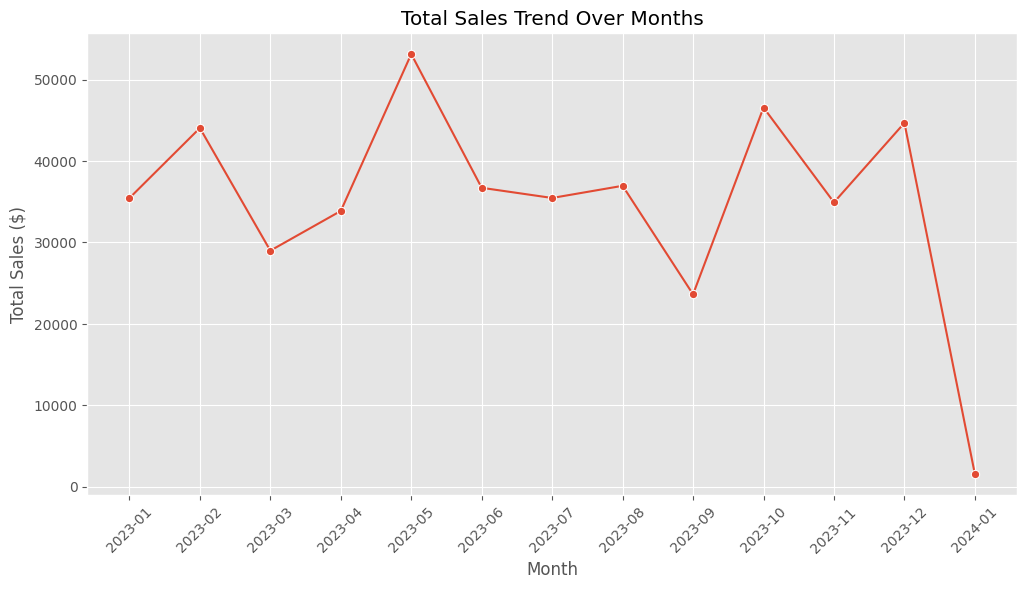

In [13]:
# 1. Sales Trend over Months
plt.figure(figsize=(12, 6))
monthly_sales = df.groupby(['year', 'month'])['total_amount'].sum().reset_index()
monthly_sales['date_str'] = monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str).str.zfill(2)

sns.lineplot(data=monthly_sales, x='date_str', y='total_amount', marker='o')
plt.title('Total Sales Trend Over Months')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.xlabel('Month')
plt.show()

C:\Users\ambar\AppData\Local\Temp\ipykernel_19392\1914871301.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, palette='viridis')


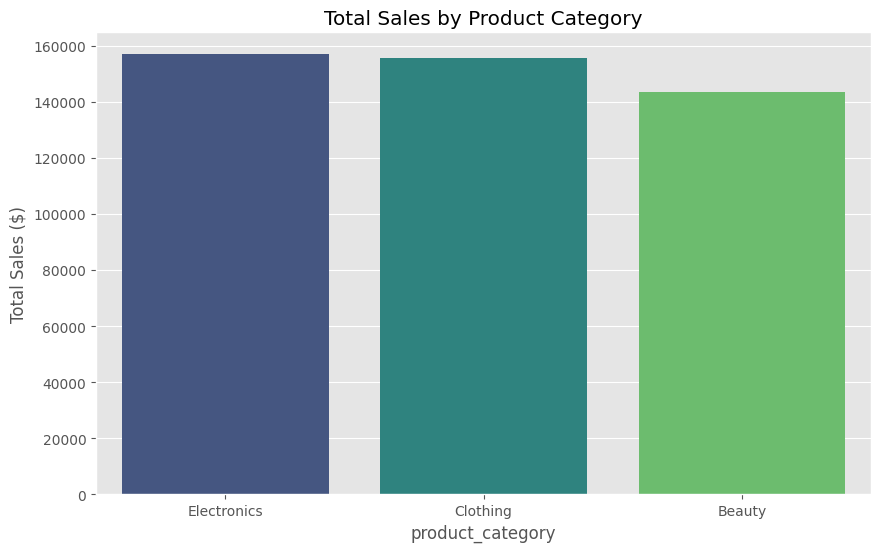

In [14]:
# 2. Sales by Product Category
plt.figure(figsize=(10, 6))
category_sales = df.groupby('product_category')['total_amount'].sum().sort_values(ascending=False)
sns.barplot(x=category_sales.index, y=category_sales.values, palette='viridis')
plt.title('Total Sales by Product Category')
plt.ylabel('Total Sales ($)')
plt.show()

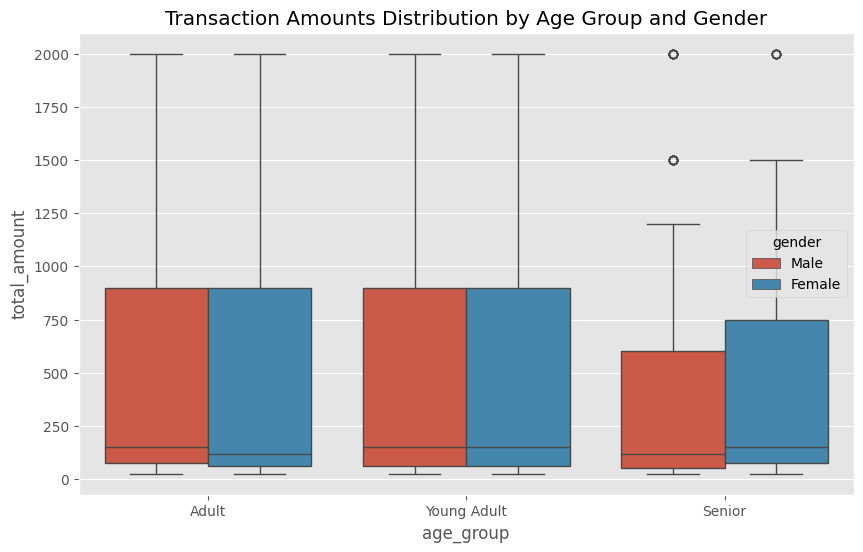

In [15]:
# 3. Sales by Gender and Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='age_group', y='total_amount', hue='gender')
plt.title('Transaction Amounts Distribution by Age Group and Gender')
plt.show()

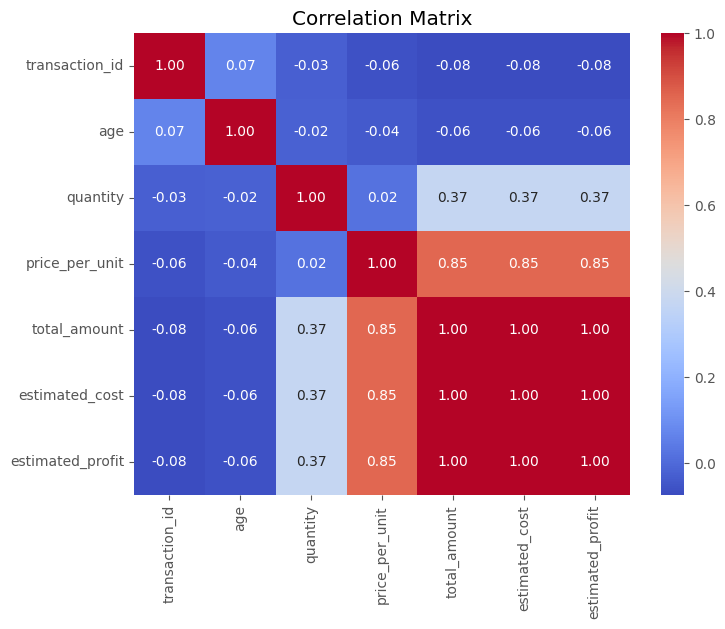

In [16]:
# 4. Correlation Matrix
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()